# Hotmart - Data Analyst Challenge

# Planejamento da Solução (IOT)

## Input 

 Sua tarefa será gerar Insights sobre os dados no dataset que disponibilizamos. Não existe uma forma única de chegar a uma solução, nem um número mínimo ou máximo de insights para serem gerados, mas, separamos algumas perguntas que seriam interessantes de serem respondidas:
 
1. A Hotmart depende dos maiores produtores da plataforma? Ou seja, os produtores que mais vendem são responsáveis pela maior parte do faturamento da Hotmart?
2. Existe algum padrão ou tendência relevante nos dados?
3. Há épocas do ano em que uma determinada categoria ou nicho de produto
vende mais?
4. Se tivéssemos que fazer uma campanha de Marketing incentivar mais
pessoas a criarem produtos em um determinado nicho, qual nicho seria esse?


## Output

* Ferramentas:
    - Github
    - Tableau
* URL para o time Analisar o código
* Download dos dados selecionados

## Tasks

* Descrição dos dados:
    - Substituição de NA's.
   
* EDA:
    - Análise Univariada
    - Análise Bivariada
    - Detecção de Outliers
    - Seleção de Features
    - Estudo do Espaço
    - Definição do Embedding
* Treinamento dos Algoritimos de ML:
    - Análise de Performance.
    - Análise de Clustering
    - Definição dos números de clustering.
* EDA - Insights:
    - Explicação das características dos segmentos.
* Tabela para armazenar os clientes clusterizados.
* Criação do notebook de produção 
* Arquitetura da AWS:
    - S3 para armazenar os dados
    - EC2 para armazenar o etl e a ferramenta de visualização 
    - DB para armazenar a tabela
    - Cronjob 
    - Papermill

# 1 - Imports

In [481]:
import math
import inflection 
import warnings
import mysql.connector

import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from sklearn  import cluster       as c 
from sklearn  import metrics       as m 
from sklearn import manifold       as mn
from sklearn  import preprocessing as pp 
from sklearn import decomposition  as dd
from datetime import datetime

sns.set(rc={'figure.figsize':(20,10)})
warnings.filterwarnings( 'ignore' )

## 0.1 Establishing the connection 

In [4]:
conn = mysql.connector.connect(
    user='admin', password='0WHPq8U2yJ9JgHVjsRBM', host='interview-2.ck1h5ksgzpiq.us-east-1.rds.amazonaws.com', database='innodb')

## 0.2 Reading the table Into a DataFrame

In [5]:
sql_query = pd.read_sql_query('''
                             SELECT * FROM sales_data''', 
                             conn)

- loading into a CSV file

In [6]:
sql_query.to_csv('/Users/rromao/Desktop/Repos/Hotmart/Hotmart-Challenge/exported_data.csv', index=False)

# 2 - Loading Data

In [4]:
df_raw = pd.read_csv('/Users/rromao/Desktop/Repos/Hotmart/Hotmart-Challenge/exported_data.csv')

In [5]:
df_raw.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1663958,6640.0,209372.0,116238.0,1200397.0,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,NaN,Smart TV,Origin ef2b,"0,0"
2,1677087,2350.0,141418.0,2821.0,1083764.0,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,NaN,Smart TV,Origin ef2b,"0,0"
3,2017360,35669.0,618642.0,618642.0,1436106.0,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,NaN,Smart TV,Origin ef2b,"0,0"
4,2017379,57998.0,1164511.0,70388.0,1436118.0,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,NaN,Smart TV,Origin ef2b,"0,0"


# 3 - Data Description

In [87]:
# Criando uma cópia para manipular a cópia do dado sem alterar 
# o Dataset Original 

df1 = df_raw.copy()

## 1.1 Rename Columns

In [88]:
df1.columns 

Index(['purchase_id', 'product_id', 'affiliate_id', 'producer_id', 'buyer_id',
       'purchase_date', 'product_creation_date', 'product_category',
       'product_niche', 'purchase_value', 'affiliate_commission_percentual',
       'purchase_device', 'purchase_origin', 'is_origin_page_social_network'],
      dtype='object')

In [89]:
cols_old = ['purchase_id', 'product_id', 'affiliate_id', 'producer_id', 'buyer_id',
       'purchase_date', 'product_creation_date', 'product_category',
       'product_niche', 'purchase_value', 'affiliate_commission_percentual',
       'purchase_device', 'purchase_origin', 'is_origin_page_social_network']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

In [90]:
# Renomeando as colunas utilizando a Biblioteca Inflection
# - Ela é uma biblioteca de transformação de Strings.
# - Ela regulariza e pluraliza palavras em inglês e transforma strings de CamelCase para Underscore

df1.columns = cols_new

## 1.2 Data Dimensions

In [91]:
print( 'Número de Linhas: {}'.format( df1.shape[0] ) )
print( 'Número de Colunas: {}'.format( df1.shape[1] ) )

Número de Linhas: 1599829
Número de Colunas: 14


## 1.3 Data Types

In [92]:
df1.dtypes

purchase_id                          int64
product_id                         float64
affiliate_id                       float64
producer_id                        float64
buyer_id                           float64
purchase_date                       object
product_creation_date               object
product_category                    object
product_niche                       object
purchase_value                     float64
affiliate_commission_percentual    float64
purchase_device                     object
purchase_origin                     object
is_origin_page_social_network       object
dtype: object

## 1.4 Check NA

In [93]:
df1.isna().sum()

purchase_id                          0
product_id                           1
affiliate_id                         1
producer_id                          1
buyer_id                             1
purchase_date                        1
product_creation_date                1
product_category                     1
product_niche                        1
purchase_value                       1
affiliate_commission_percentual    200
purchase_device                      1
purchase_origin                      1
is_origin_page_social_network        0
dtype: int64

## 1.5 Fillout NA

In [94]:
df1.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1663958,6640.00,209372.00,116238.00,1200397.00,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.27,NaN,Smart TV,Origin ef2b,"0,0"
2,1677087,2350.00,141418.00,2821.00,1083764.00,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.18,NaN,Smart TV,Origin ef2b,"0,0"
3,2017360,35669.00,618642.00,618642.00,1436106.00,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.47,NaN,Smart TV,Origin ef2b,"0,0"
4,2017379,57998.00,1164511.00,70388.00,1436118.00,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.40,NaN,Smart TV,Origin ef2b,"0,0"


In [95]:
df1['product_id'].fillna(0, inplace=True)
df1['affiliate_id'].fillna(0, inplace=True)
df1['producer_id'].fillna(0, inplace=True)
df1['buyer_id'].fillna(0, inplace=True)
df1['product_category'].fillna(0, inplace=True)
df1['product_niche'].fillna(0, inplace=True)
df1['purchase_value'].fillna(0, inplace=True)
df1['affiliate_commission_percentual'].fillna(0, inplace=True)
df1['purchase_device'].fillna(0, inplace=True)
df1['purchase_origin'].fillna(0, inplace=True)


In [96]:
df1['purchase_date'].fillna(0, inplace=True)
df1['product_creation_date'].fillna(0, inplace=True)

In [97]:
df1.isna().sum()

purchase_id                        0
product_id                         0
affiliate_id                       0
producer_id                        0
buyer_id                           0
purchase_date                      0
product_creation_date              0
product_category                   0
product_niche                      0
purchase_value                     0
affiliate_commission_percentual    0
purchase_device                    0
purchase_origin                    0
is_origin_page_social_network      0
dtype: int64

In [98]:
df1.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,0,0.00,0.00,0.00,0.00,0,0,0,0,0.00,0.00,0,0,0
1,1663958,6640.00,209372.00,116238.00,1200397.00,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.27,0.00,Smart TV,Origin ef2b,"0,0"
2,1677087,2350.00,141418.00,2821.00,1083764.00,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.18,0.00,Smart TV,Origin ef2b,"0,0"
3,2017360,35669.00,618642.00,618642.00,1436106.00,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.47,0.00,Smart TV,Origin ef2b,"0,0"
4,2017379,57998.00,1164511.00,70388.00,1436118.00,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.40,0.00,Smart TV,Origin ef2b,"0,0"


## 1.6 Change Data Types

In [99]:
df1['purchase_date'] = pd.to_datetime(df1['purchase_date'], errors='coerce')
df1['product_creation_date'] = pd.to_datetime(df1['product_creation_date'], errors='coerce')

In [100]:
df1.dtypes

purchase_id                                 int64
product_id                                float64
affiliate_id                              float64
producer_id                               float64
buyer_id                                  float64
purchase_date                      datetime64[ns]
product_creation_date              datetime64[ns]
product_category                           object
product_niche                              object
purchase_value                            float64
affiliate_commission_percentual           float64
purchase_device                            object
purchase_origin                            object
is_origin_page_social_network              object
dtype: object

In [101]:
df1['product_id'] = df1['product_id'].astype( int )
df1['affiliate_id'] = df1['affiliate_id'].astype( int )
df1['producer_id'] = df1['producer_id'].astype( int )
df1['buyer_id'] = df1['buyer_id'].astype( int )

## 1.7 Descriptive Statistics

1. Estimativas de Localização:
    
    1. Média
    2. Mediana
    3. Mínimo
    4. Máximo
    
2. Estimativas de Variabilidade:
    
    1. Desvio
    2. Variância 
    3. Desvio Padrão
    4. Range( Intervalo )
    
3. Skewness:
    
4. Kurtosis:

In [102]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [103]:
cols_drop = ['purchase_id','product_id','affiliate_id', 'producer_id', 'buyer_id','affiliate_id']
num_attributes = num_attributes.drop(columns= cols_drop )

### 1.7.1 Numerical attributes

In [104]:
# Estimadore de localização ( Media, Mediana, Min, Max )

est1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
est2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
est3 = pd.DataFrame( num_attributes.apply( np.min ) ).T
est4 = pd.DataFrame( num_attributes.apply( np.max ) ).T

# estimadores de variabilizade (Desvio Padrão, Range )

est5 = pd.DataFrame( num_attributes.apply( np.std ) ).T
est6 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

# skewness e Kurtosis

est7 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
est8 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# Concatenando
pd.options.display.float_format = '{:.2f}'.format
m1 = pd.concat( [ est3, est4, est6, est1, est2, est5, est7, est8] ).T.reset_index()

m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'desvio_padrao', 'skewness', 'kurtosis']

# percentis 

quartis = num_attributes.apply( lambda x: np.percentile( x, q=[10, 25, 50, 75, 95, 99] ) ).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']

#
m2 = pd.merge(m1, quartis, how='inner', on='attributes')
m2


,attributes,min,max,range,media,mediana,desvio_padrao,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,purchase_value,-0.54,124.56,125.10,0.00,-0.35,1.00,10.82,629.21,-0.51,-0.45,-0.35,0.06,1.65,3.84
1,affiliate_commission_percentual,0.00,100.00,100.00,7.60,0.00,18.48,2.26,3.75,0.00,0.00,0.00,0.00,55.00,70.00


<AxesSubplot:xlabel='purchase_value'>

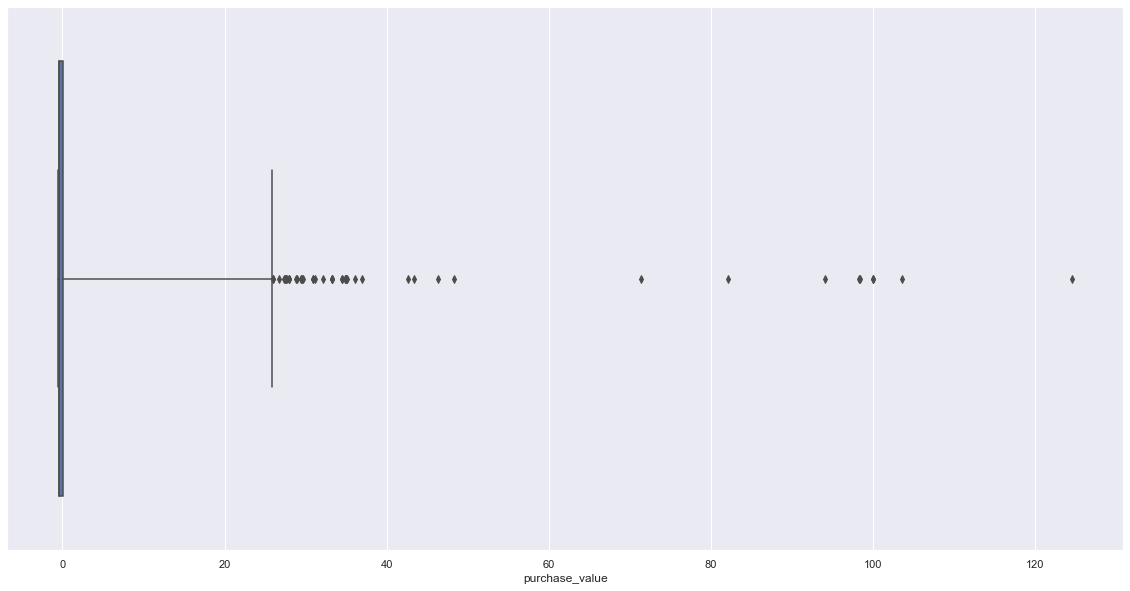

In [470]:
plt.figure( figsize=(20,10 ) )
sns.boxplot( x='purchase_value',whis=50, data=num_attributes )

<AxesSubplot:xlabel='purchase_value'>

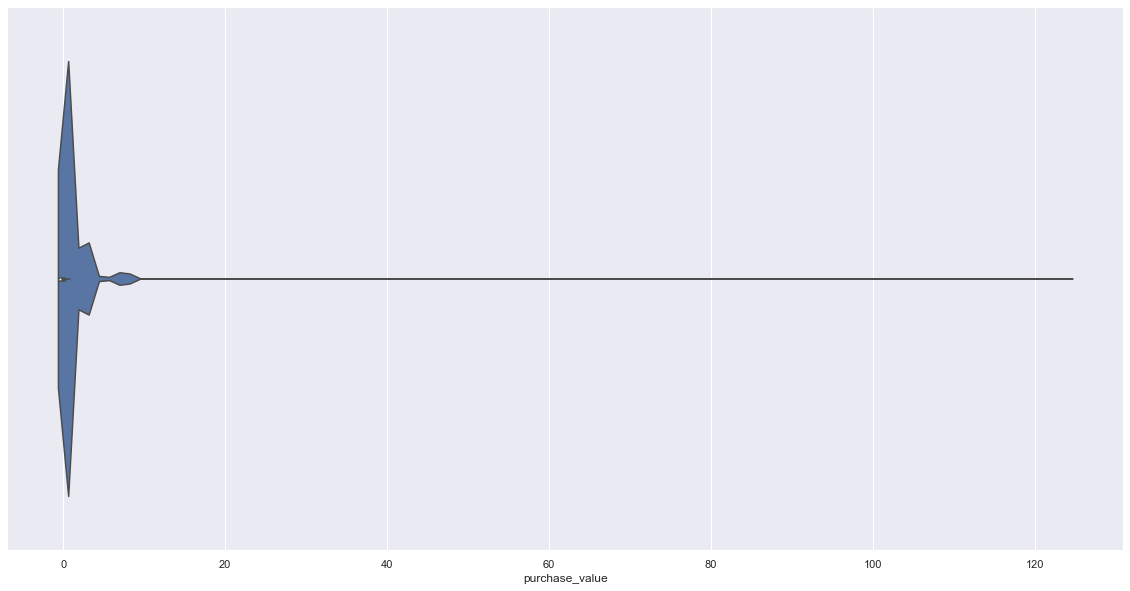

In [475]:
plt.figure( figsize=(20,10 ) )
sns.violinplot( x='purchase_value', data=num_attributes )

<AxesSubplot:xlabel='purchase_value', ylabel='Count'>

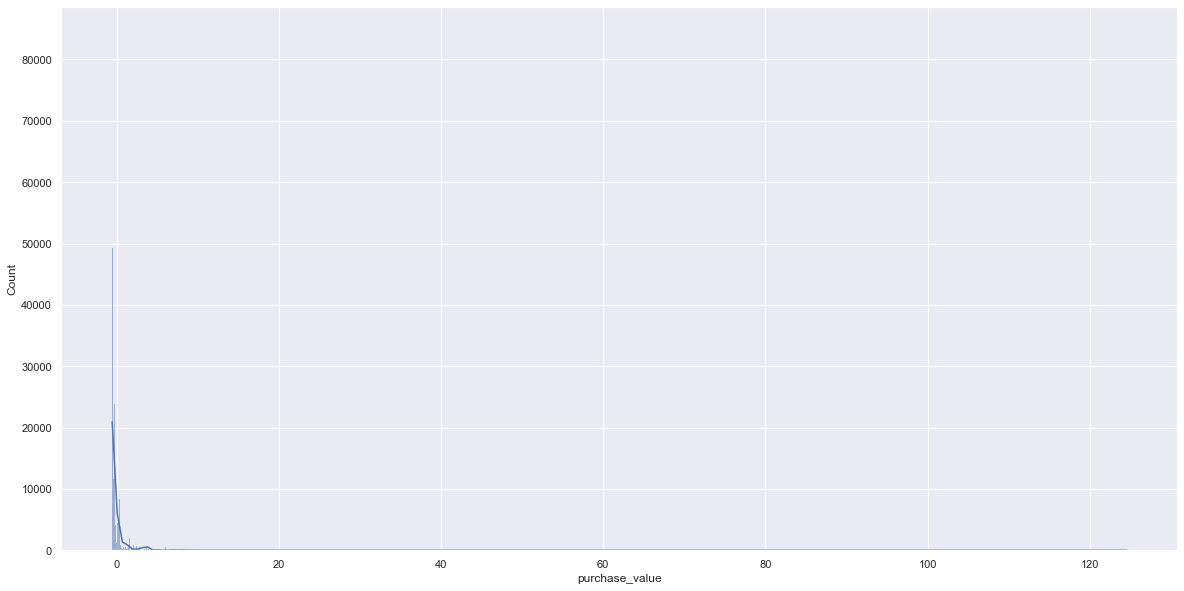

In [480]:
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='purchase_value', kde=True, data=num_attributes)

### 1.7.2 Categorical Attributes

In [105]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

product_category                   11
product_niche                      26
purchase_device                     6
purchase_origin                  9604
is_origin_page_social_network       3
dtype: int64

<AxesSubplot:xlabel='product_category', ylabel='Percent'>

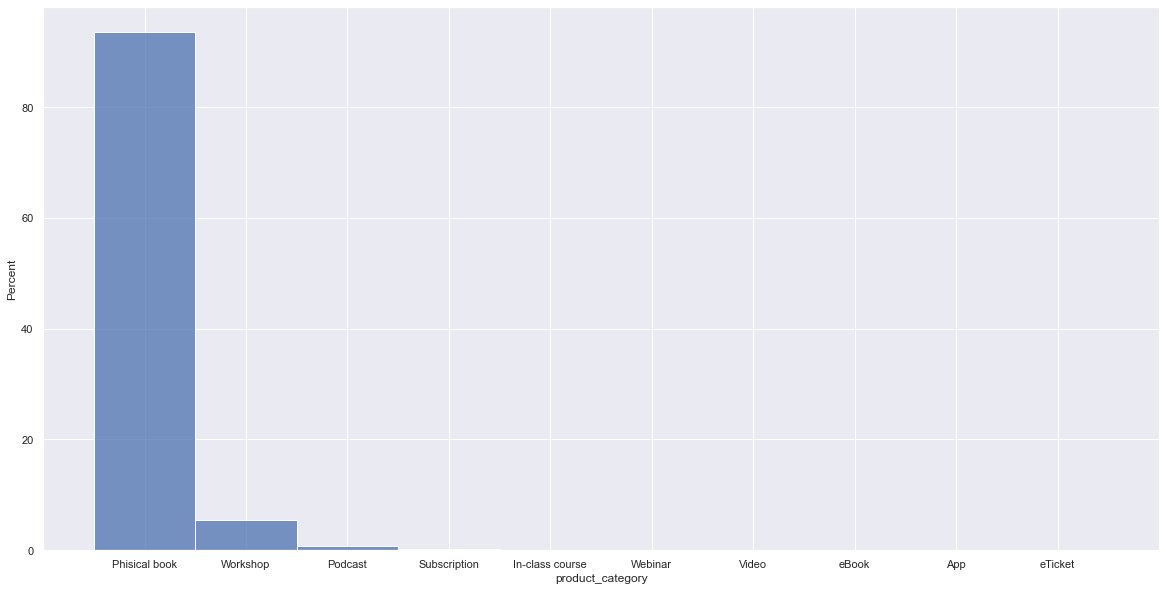

In [106]:
aux = df1[(df1['product_category'] != '0') & (df1['purchase_value'] > 0)]



plt.figure(figsize=(20,10 ))
sns.histplot(x='product_category', data=aux, stat="percent", discrete=True)

# 4 - Data Filtering

In [107]:
df2 = df1.copy()
df2.head(5)

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,0,0,0,0,0,1970-01-01 00:00:00,1970-01-01 00:00:00,0,0,0.00,0.00,0,0,0
1,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.27,0.00,Smart TV,Origin ef2b,"0,0"
2,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.18,0.00,Smart TV,Origin ef2b,"0,0"
3,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.47,0.00,Smart TV,Origin ef2b,"0,0"
4,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.40,0.00,Smart TV,Origin ef2b,"0,0"


In [322]:
#Eliminei a primeira linha, pois era uma única compra efetuada em 1970 e adicionei o resultado ao DF2
aux1 = df3.drop(labels=0, axis=0)
df3 = aux1

# 5 - Feature Engineering

In [18]:
# Fato

#Compra = Fato (Soma, Contar, Maior, Menor, Media, Mediana)
#Cliente entrou na base = Fato
#Devolução = Fato

# Dimensão

# Tempo( Ano, mês, dia, hora, minuto)
# Espaço ( Localização, região, lat, long, bairro, rua )
# Produto( Nome, Tipo, Categoria, Preço, Condição de Compra)
# Marketing (Organica, Paid ( Facebook, Google))

In [320]:
df3 = df2.copy()

In [321]:
# Criando novas Features

# year
df3['year'] = df3['purchase_date'].dt.year

# month
df3['month'] = df3['purchase_date'].dt.month

# day
df3['day'] = df3['purchase_date'].dt.day

# year week
df3['year_week'] = df3['purchase_date'].dt.strftime( '%Y-%W' )

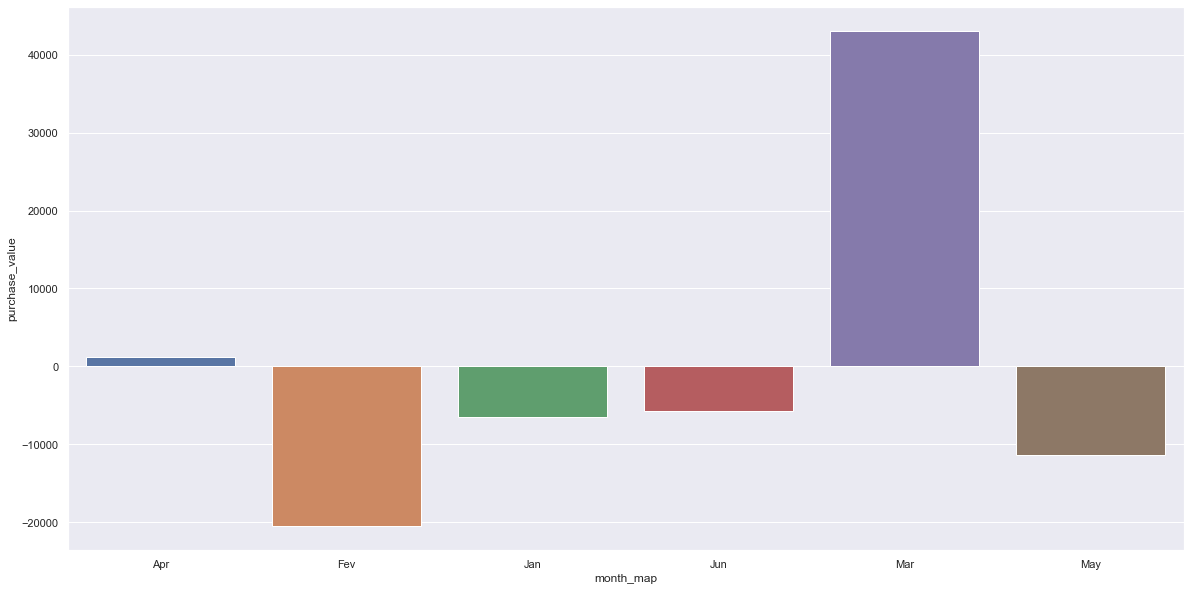

In [323]:

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df3['month_map'] = df3['purchase_date'].dt.month.map( month_map )
aux2 = df3[['month_map', 'purchase_value']].groupby( 'month_map' ).sum().reset_index()
sns.barplot( x='month_map', y='purchase_value', hue=None, data=aux2 );

In [359]:
df_ref = df3.drop([ 'product_niche', 'product_creation_date', 'affiliate_commission_percentual', 'purchase_device','purchase_origin', 'is_origin_page_social_network' ], axis=1).drop_duplicates(ignore_index=True)

In [360]:
df_ref.isna().sum()

purchase_id         0
product_id          0
affiliate_id        0
producer_id         0
buyer_id            0
purchase_date       0
product_category    0
purchase_value      0
year                0
month               0
day                 0
year_week           0
month_map           0
dtype: int64

### Monetary 

In [361]:

df_monetary = df_ref.loc[: , ['buyer_id', 'purchase_value']].groupby('buyer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on='buyer_id', how='left')

### Recency - Last Purchase day 

In [364]:
# Utilizado para saber quanto tempo tem a última compra

df_recency = df_ref.loc[:, ['buyer_id', 'purchase_date']].groupby('buyer_id').max().reset_index()

df_recency['recency_days'] = (df3['purchase_date'].max() - df3['purchase_date'] ).dt.days

df_recency = df_recency[['buyer_id', 'recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, on='buyer_id', how='inner')


### Quantity of purchased products

In [366]:
# Número de Produtos comprados 
df_freq = df3[['buyer_id', 'purchase_id']].groupby('buyer_id').count().reset_index().rename(columns={'purchase_id':'product_amount'})
        
df_ref = pd.merge(df_ref, df_freq, on='buyer_id', how='left')
df_ref.isna().sum()

purchase_id         0
product_id          0
affiliate_id        0
producer_id         0
buyer_id            0
purchase_date       0
product_category    0
purchase_value_x    0
year                0
month               0
day                 0
year_week           0
month_map           0
purchase_value_y    0
recency_days        2
product_amount_x    0
product_amount_y    0
dtype: int64

In [252]:
df_ref['purchase_value'].fillna(0, inplace=True)
df_ref['recency_days_y'].fillna(0, inplace=True)

### Purchase Frequency 

In [409]:
df_aux = (df3[['buyer_id', 'purchase_id', 'purchase_date']].drop_duplicates()
                                                 .groupby('buyer_id')
                                                 .agg( max_  = ('purchase_date', 'max' ), 
                                                       min_  = ('purchase_date', 'min' ),
                                                       days_ = ('purchase_date', lambda x: ( ( x.max() - x.min() ).days  ) + 1 ),
                                                       buy_  = ('purchase_id', 'count' ) ) ).reset_index()
df_aux.head(25)

,buyer_id,max_,min_,days_,buy_
0,60,2016-03-13 12:55:15,2016-03-07 09:10:28,7,2
1,65,2016-06-13 19:15:31,2016-01-13 17:55:51,153,6
2,80,2016-04-27 18:23:46,2016-04-27 18:23:46,1,1
3,91,2016-04-27 17:46:31,2016-01-27 22:44:33,91,4
4,115,2016-02-04 10:35:02,2016-02-04 10:35:02,1,1
5,120,2016-02-27 02:41:24,2016-02-27 02:41:24,1,1
6,136,2016-06-25 15:16:57,2016-01-22 19:57:46,155,5
7,139,2016-03-07 23:45:51,2016-03-07 23:45:51,1,1
8,169,2016-03-01 18:52:24,2016-03-01 18:52:24,1,1
9,202,2016-06-26 17:27:49,2016-06-26 17:27:49,1,1


In [411]:
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

In [415]:
# merge
df_ref = pd.merge(df_ref, df_aux[['buyer_id', 'frequency']], on='buyer_id', how='left')


In [417]:
cols_drop = ['affiliate_id','product_category', 'purchase_date','year', 'month', 'day', 'year_week', 'purchase_value_y','product_amount_y', 'frequency_y']
df_ref1 = df_ref.drop(columns=cols_drop, axis=1)

# 6 - EDA ( Exploratory Data Analysis )

In [372]:
df4 = df_ref.dropna()
df4.isna().sum()

purchase_id         0
product_id          0
affiliate_id        0
producer_id         0
buyer_id            0
purchase_date       0
product_category    0
purchase_value_x    0
year                0
month               0
day                 0
year_week           0
month_map           0
purchase_value_y    0
recency_days        0
product_amount_x    0
product_amount_y    0
frequency           0
dtype: int64

## 6.1 Univariate Analysis

<AxesSubplot:xlabel='purchase_value_x'>

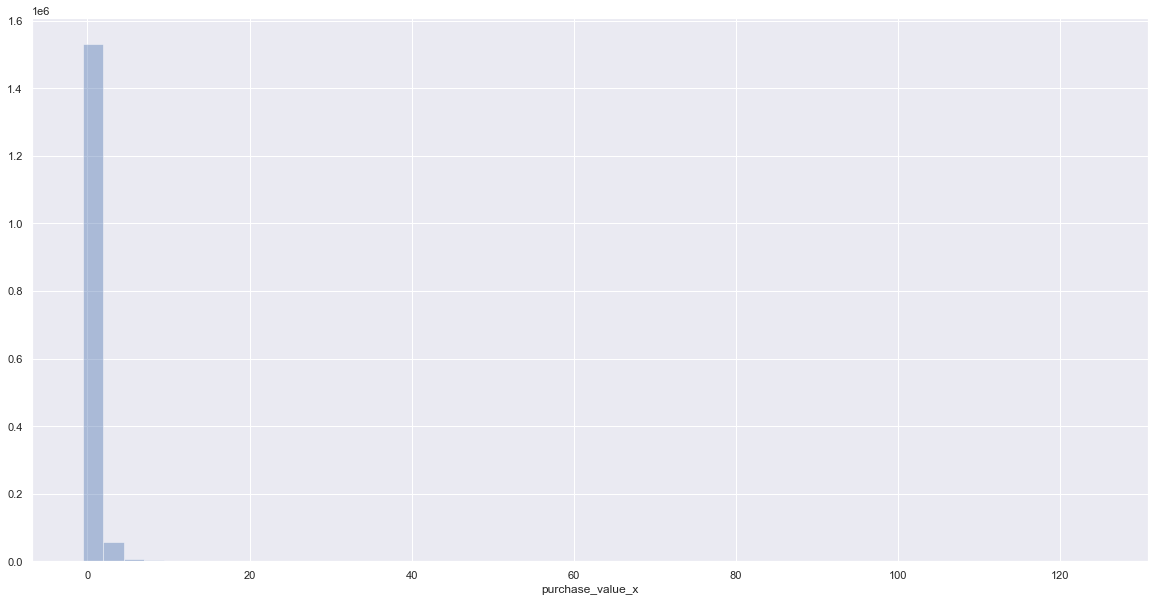

In [482]:
sns.distplot( df4['purchase_value_x'], kde=False )

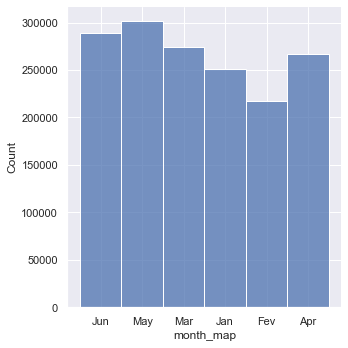

In [489]:
aux00 = df4.loc[df4['frequency'] != 0, 'month_map']
sns.displot( aux00)

<AxesSubplot:xlabel='month_map', ylabel='purchase_value_x'>

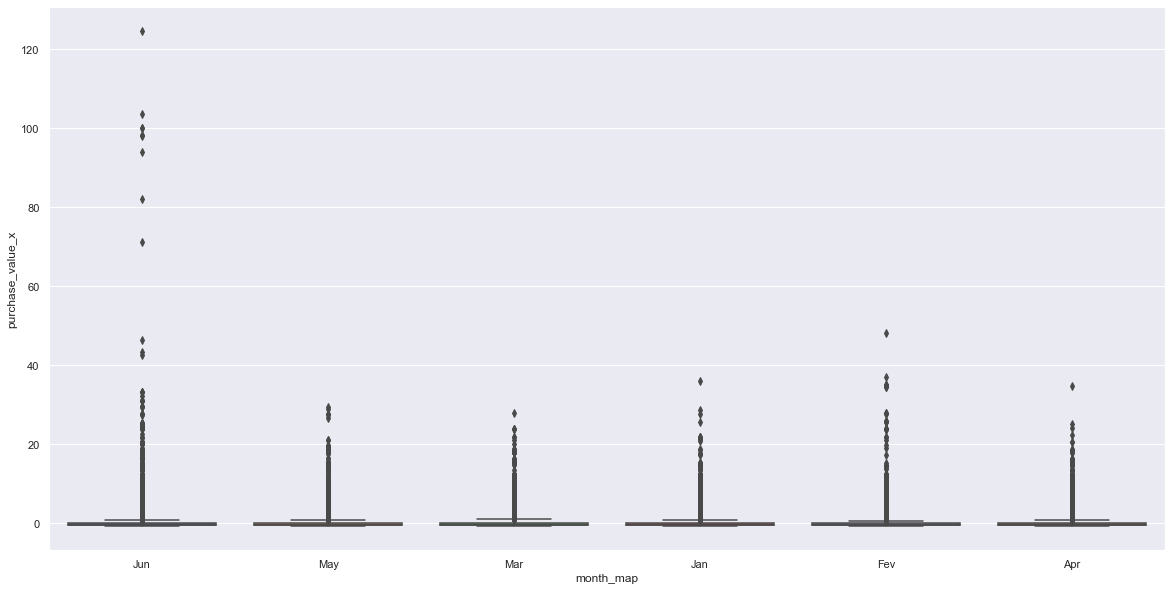

In [494]:
# Monthly Revenue
sns.boxplot(x='month_map', y='purchase_value_x', data=df4)

## 6.2 Numerical Variable


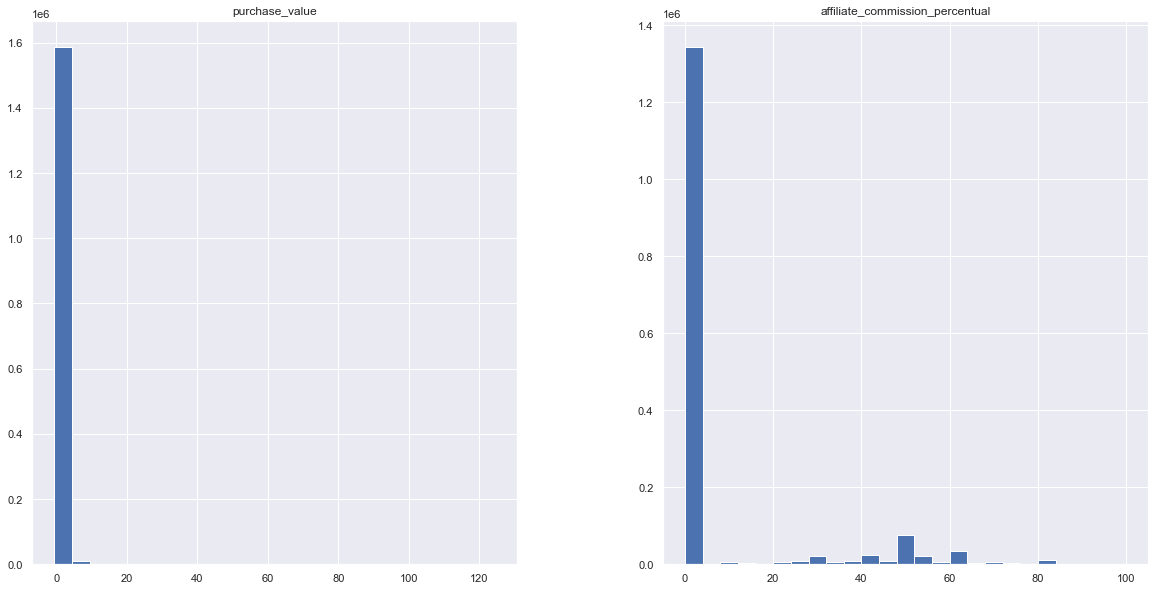

In [496]:

sns.set(rc={'figure.figsize':(20,10)})

num_attributes.hist( bins=25);

## 6.3 Multivariate Analysis

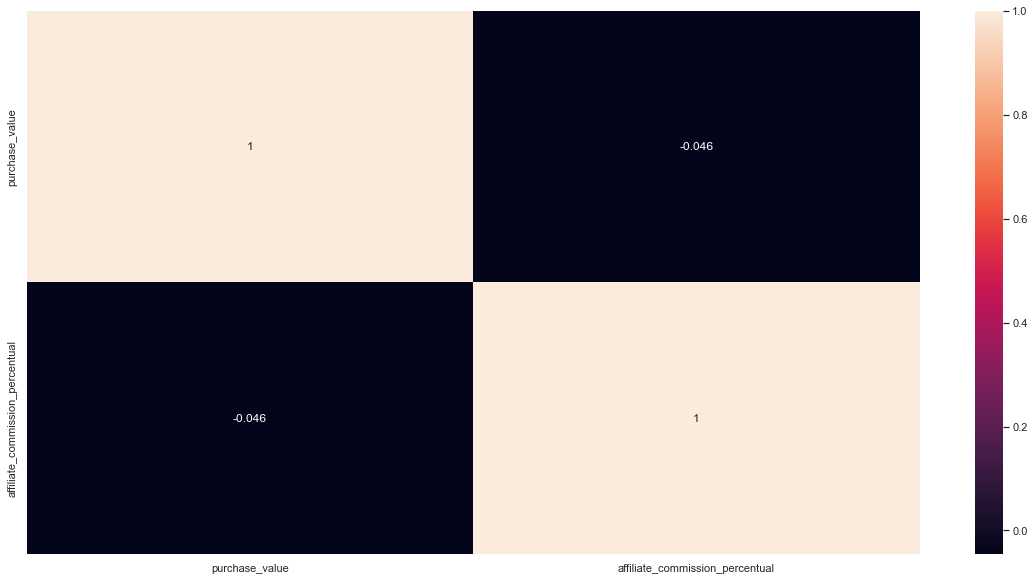

In [501]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

  ## 6.1 Space Study

In [373]:
cols_selected = ['buyer_id', 'recency_days','product_amount_x', 'frequency']
df43 = df4[ cols_selected].drop(columns='buyer_id', axis=1)



In [375]:
mm = pp.MinMaxScaler()

df43['recency_days']  = mm.fit_transform( df43[['recency_days']] )
df43['product_amount_x'] = mm.fit_transform( df43[['product_amount_x']])
df43['frequency']     = mm.fit_transform( df43[['frequency']])

X = df43.copy()

In [377]:
X.shape

(1599826, 3)

## 6.2 PCA

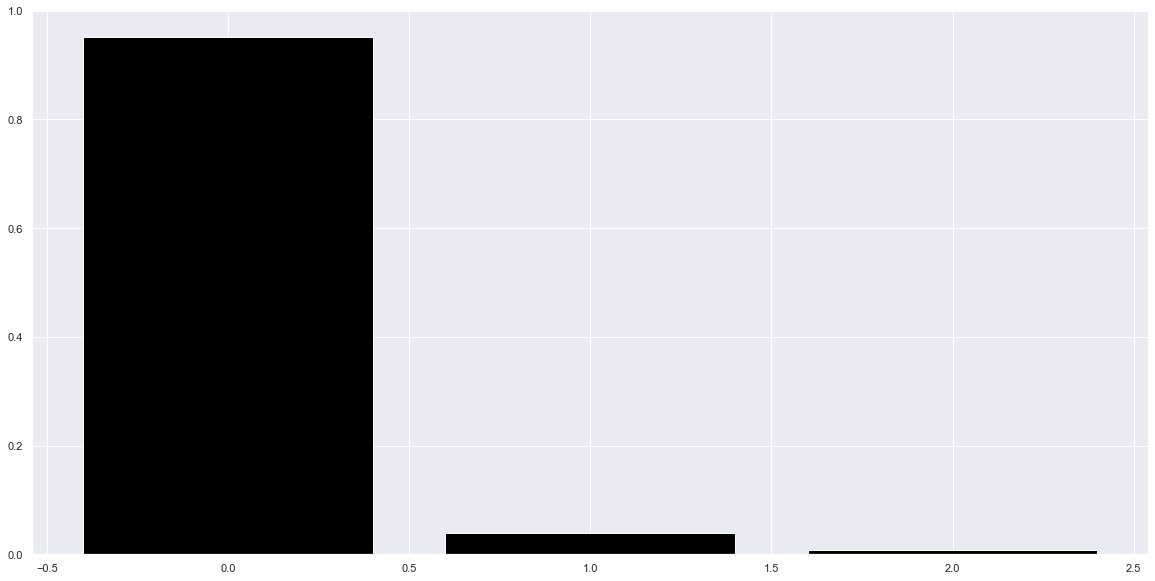

In [380]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

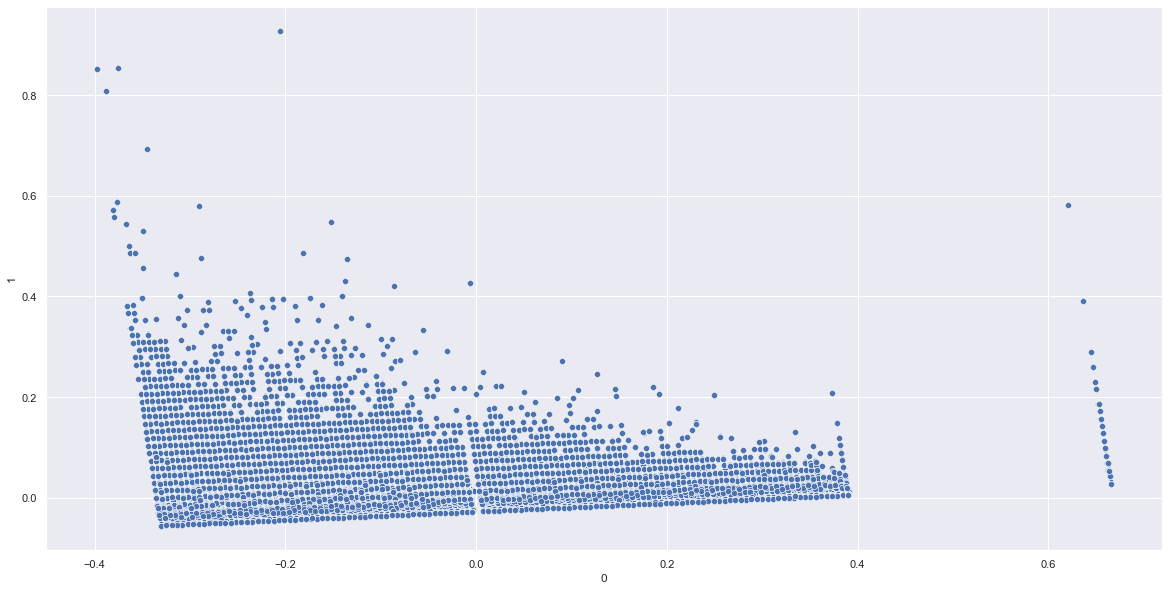

In [381]:
sns.scatterplot( x=0, y=1, data=df_pca ) 

## 6.3 UMAP

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

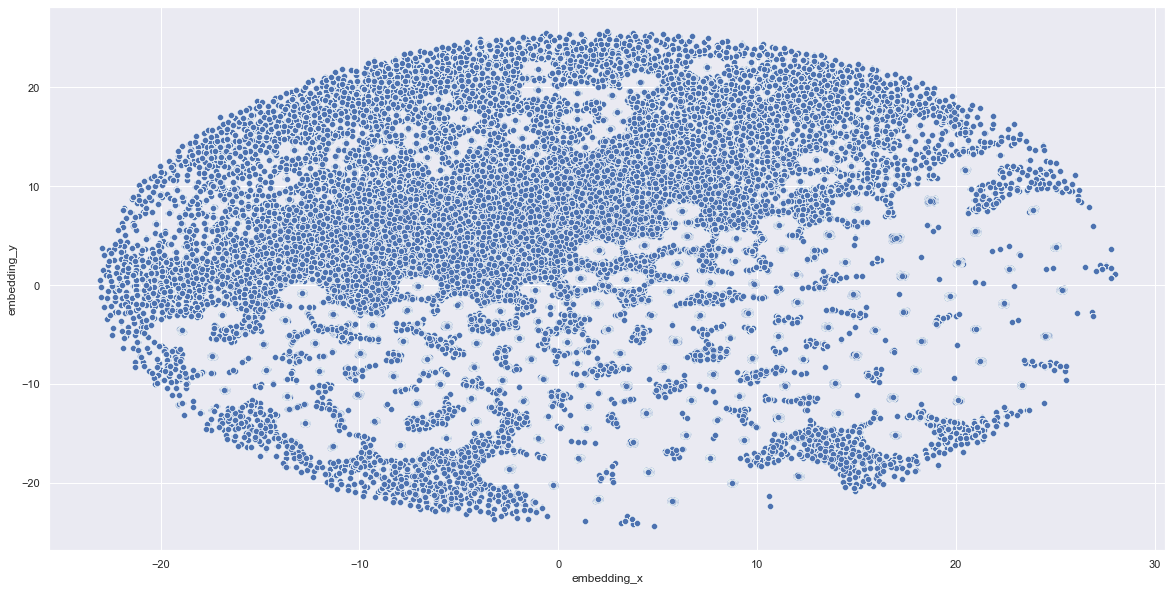

In [393]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

# 7 - Insights Answer

In [132]:
# Quantidade de compras que foram efetuada diretamente pelo produtor, não tiveram afiliados intermediando. 

with_affiliates = df2[df2['producer_id'] == df2['affiliate_id']]
non_affiliates = df2[df2['producer_id'] != df2['affiliate_id']]


print('Foram {} compras que tiveram afiliados como intermediário no processo da compra'.format(with_affiliates.shape[0]))
print('Foram {} compras que não tiveram afiliados como intermediário no processo da compra'.format(non_affiliates.shape[0]))


Foram 1247083 compras que tiveram afiliados como intermediário no processo da compra
Foram 352746 compras que não tiveram afiliados como intermediário no processo da compra


In [140]:
# Os produtores com mais produtos vendidos
aux5 = df3[['producer_id', 'product_id']].groupby('product_id').sum()
aux5.sort_values(by='product_id', ascending=False).reset_index().head(10)

,product_id,producer_id
0,319129,19736962
1,241977,5485486
2,241903,3258640
3,241896,2386770
4,241745,1482909
5,241639,27661592
6,241490,40487661
7,241299,2697187
8,241145,191642739
9,240950,62450112


In [152]:
# Das Compras efetuadas por intermédio de um afiliado qual foi a maior compra


test = with_affiliates[[ 'producer_id','purchase_value', 'affiliate_commission_percentual']].groupby('producer_id').max().reset_index()
test.sort_values(by='purchase_value', ascending=False)

,producer_id,purchase_value,affiliate_commission_percentual
5954,5230700,124.56,0.00
924,409590,48.26,0.00
5737,4993899,46.32,0.00
2984,1968219,43.35,0.00
5265,4554369,42.63,0.00
...,...,...,...
263,55338,-0.54,0.00
6137,5379733,-0.54,0.00
7576,7341877,-0.54,0.00
7031,6545494,-0.54,0.00


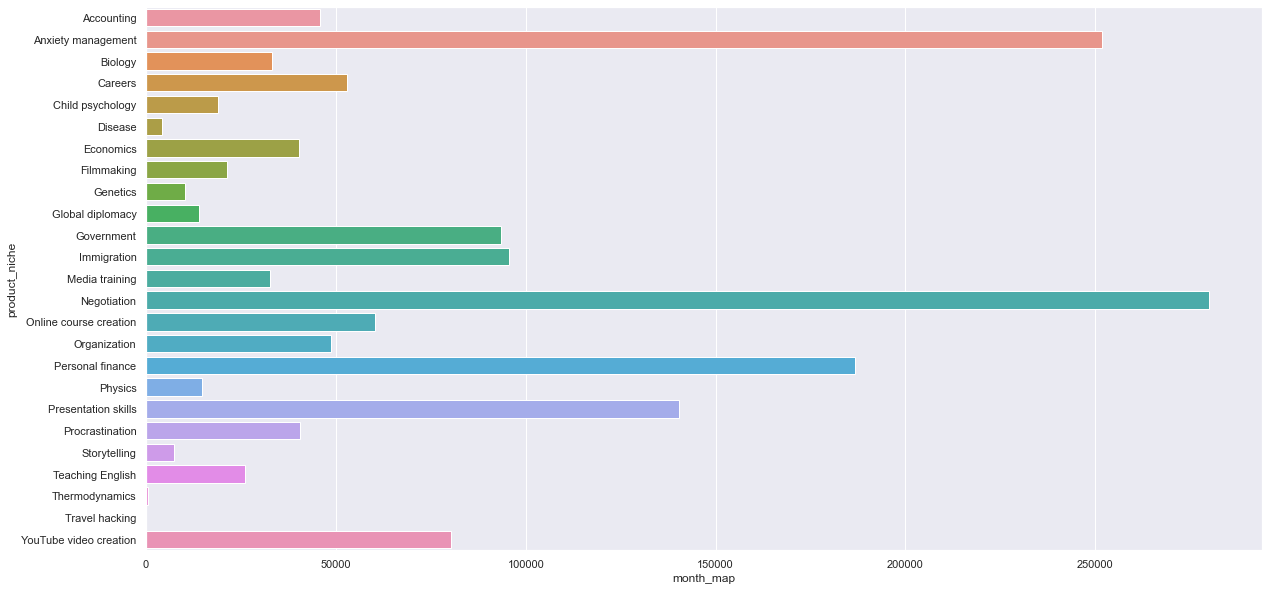

In [403]:
sales_per_niche = df3[['product_niche', 'month_map']].groupby('product_niche').count().reset_index()
sns.barplot( x='month_map', y='product_niche', data=sales_per_niche );

<AxesSubplot:xlabel='buyer_id', ylabel='product_amount_x'>

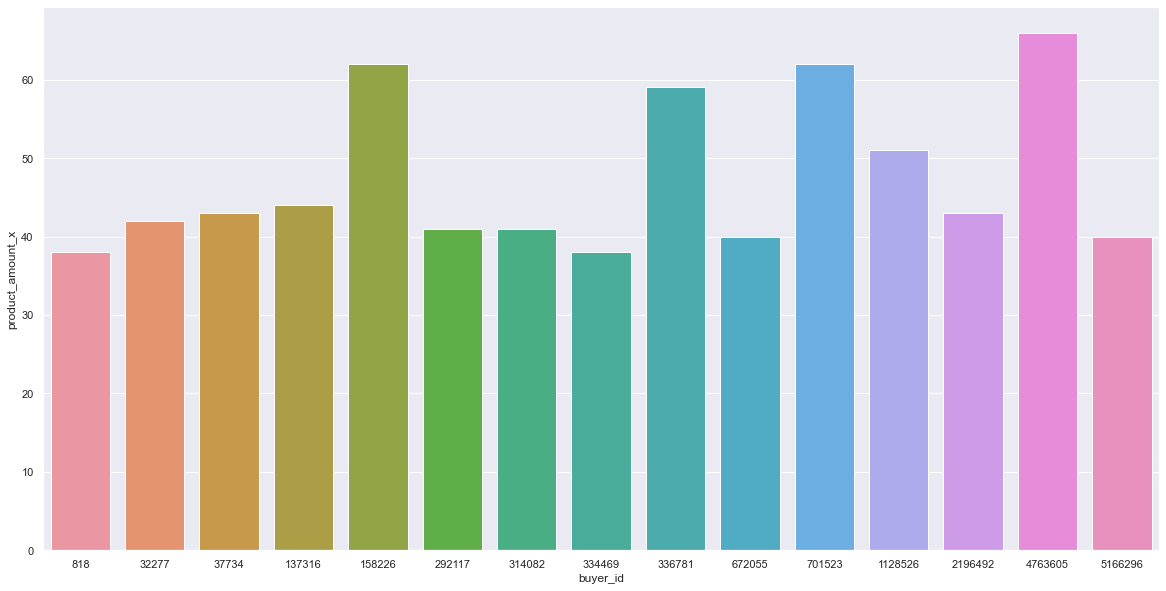

In [453]:
# Clientes que compraram acima de 30 cursos e precisam ser retidos
best_buyers = df_ref1[['buyer_id', 'product_amount_x']].groupby('buyer_id').count().sort_values(by='product_amount_x', ascending=False).head(15).reset_index()
sns.barplot( x='buyer_id', y='product_amount_x', data=best_buyers )